## Real World Data

In [1]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile
import os

output_dir = os.path.join("data", "phase3")
if not os.path.exists(output_dir):  # Check if the directory already exists
    os.makedirs(output_dir)  # Create the directory if it doesn't exist

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = os.path.join(output_dir, "dlav_train.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "train")):  # Check if the directory already exists    
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)


download_url = "https://drive.google.com/uc?id=17DREGym_-v23f_qbkMHr7vJstbuTt0if"
output_zip = os.path.join(output_dir, "dlav_val.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "val")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)


download_url = "https://drive.google.com/uc?id=1_l6cui0pCJ_caixN0uTkkUOfu6ICO8u5"
output_zip = os.path.join(output_dir, "dlav_test_public.zip")

if not os.path.exists(output_zip):  # Check if the file already exists
    gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
if not os.path.exists(os.path.join(output_dir, "test_public")):  # Check if the directory already exists
    with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
        zip_ref.extractall(output_dir)

## Visualize Real World Data

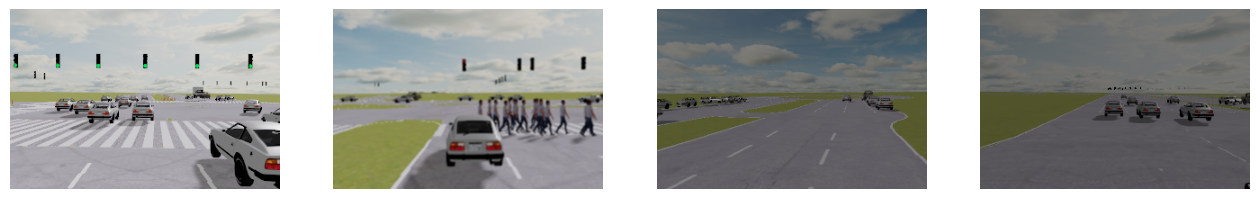

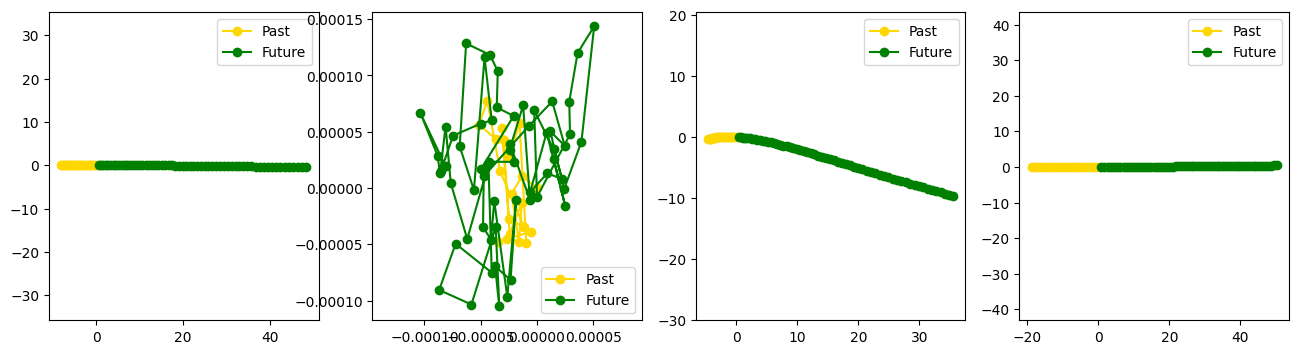

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'sdc_future_feature', 'semantic_label'])

: 

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import os
k = 4
# load the data
data = []
test_files_path = "data/phase3/augmented_all_train"
test_files = [os.path.join(test_files_path, f) for f in os.listdir(test_files_path) if f.endswith('.pkl')]
# Randomly select k files from the validation set
random.seed(42)  # Set seed for reproducibility
file_set = random.sample(test_files, k)

for i in range(k):
    with open(file_set[i], "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()
# print the content of the data
data[0].keys()  # Display the keys of the first data entry to understand its structure

## Dataset Class

In [4]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import csv
import random
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)
        data.keys()  # Display the keys of the data entry to understand its structure
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])
        
        semantic = torch.LongTensor(data['semantic_label'])
        if semantic.shape[-2:] != (200, 300):
            semantic = TF.resize(semantic.unsqueeze(0).float(), size=(200, 300), interpolation=TF.InterpolationMode.NEAREST).long().squeeze(0)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'future': future,
                'semantic': semantic
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'semantic': semantic
            }

## Data Augmentation

In [5]:
import os
import random
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm

def augment_and_save(file_list, save_dir, flip_ratio=0.5):
    """Horizontal flip augmentation for both camera and semantic data with randomness"""
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    # Randomly select files to flip based on flip_ratio
    selected_files = random.sample(file_list, int(len(file_list) * flip_ratio))

    for file_path in tqdm(selected_files, desc="Horizontal flip augmentation"):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        # Flip camera image horizontally
        camera = data['camera'][:, ::-1, :]  # shape HxWxC, flip width

        # Flip semantic labels horizontally
        semantic = data['semantic_label'][:, ::-1]  # shape HxW, flip width

        # Update data
        data['camera'] = camera
        data['semantic_label'] = semantic
        data['sdc_history_feature'][:, 1:] *= -1

        if 'sdc_future_feature' in data:
            data['sdc_future_feature'][:, 1:] *= -1

        # Save to new file
        base = os.path.basename(file_path)
        new_path = os.path.join(save_dir, f"flipped_{base}")
        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files


augmented_train_path = os.path.join("data", "phase3", "augmented_train")
if not os.path.exists(augmented_train_path):
    train_data_dir = os.path.join("data", "phase3", "train")
    train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
    augmented_train = augment_and_save(train_files, save_dir=augmented_train_path)
else:
    print("Augmented training data already exists. Skipping augmentation.")

val_train_path = os.path.join("data", "phase3", "augmented_val")
if not os.path.exists(val_train_path):
    val_data_dir = os.path.join("data", "phase3", "val_real")
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]
    augmented_val = augment_and_save(val_files, save_dir=val_train_path)
else:
    print("Augmented validation data already exists. Skipping augmentation.")

val_semantics_path = os.path.join("data", "phase3", "augmented_val_semantics")
if not os.path.exists(val_semantics_path):
    val_semantics_dir = os.path.join("data", "phase3", "val_real_semantics")
    val_semantics_files = [os.path.join(val_semantics_dir, f) for f in os.listdir(val_semantics_dir) if f.endswith('.pkl')]
    augmented_val_semantics = augment_and_save(val_semantics_files, save_dir=val_semantics_path)
else:
    print("Augmented validation with semantics data already exists. Skipping augmentation.")

Augmented training data already exists. Skipping augmentation.
Augmented validation data already exists. Skipping augmentation.
Augmented validation with semantics data already exists. Skipping augmentation.


## More data augmentation on val data

In [6]:
import cv2
import numpy as np
import random
import os
import pickle
from tqdm import tqdm

# --- Augmentation functions ---

def adjust_brightness(image, bright_thresh=110, dark_thresh=90):
    """
    Adjust brightness adaptively and safely.
    - Input: image in uint8 format
    - Output: image in uint8 format
    """
    if image.dtype != np.uint8:
        raise ValueError("Expected input image in uint8 format")

    # Compute mean brightness from grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = gray.mean()
    # Choose factor based on brightness level
    if mean_brightness > bright_thresh:
        factor = np.random.uniform(0.5, 0.8)  # darken
    elif mean_brightness < dark_thresh:
        factor = np.random.uniform(1.2, 1.5)  # brighten
    else:
        factor = np.random.uniform(0.8, 1.2)  # mild change

    # Convert to float for safe scaling
    image = image.astype(np.float32)
    image = image * factor
    image = np.clip(image, 0, 255)
    return image.astype(np.uint8)

def apply_blur(image):
    k = random.choice([1, 3, 5])
    return cv2.GaussianBlur(image, (k, k), 0)

def add_noise(image, noise_level=15):
    noise = np.random.normal(0, noise_level, image.shape).astype(np.int16)
    image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return image

def apply_gamma(image, gamma_range=(0.5, 1.5)):
    gamma = np.random.uniform(*gamma_range)
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# --- Helper to apply and save ---

def apply_augmentation_to_subset(file_list, save_dir, augmentation_fn, suffix, ratio):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    selected_files = random.sample(file_list, int(len(file_list) * ratio))

    for file_path in tqdm(selected_files, desc=f"Applying {suffix}"):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        image = data['camera']
        aug_image = augmentation_fn(image)
        data['camera'] = aug_image
        base = os.path.basename(file_path)
        new_filename = f"{suffix}_{base}"
        new_path = os.path.join(save_dir, new_filename)

        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

# --- Main driver ---

def incremental_augmentation(file_list, save_dir, ratios):
    os.makedirs(save_dir, exist_ok=True)
    all_files = list(file_list)  # Start with original + flipped

    stage1 = apply_augmentation_to_subset(
        all_files, save_dir, apply_gamma, 'gamma', ratios.get('gamma', 0.5)
    )
    all_files += stage1

    stage2 = apply_augmentation_to_subset(
        all_files, save_dir, add_noise, 'noise', ratios.get('noise', 0.5)
    )
    all_files += stage2

    stage3 = apply_augmentation_to_subset(
        all_files, save_dir, adjust_brightness, 'bright', ratios.get('brightness', 0.5)
    )
    all_files += stage3

    stage4 = apply_augmentation_to_subset(
        all_files, save_dir, apply_blur, 'blur', ratios.get('blur', 0.5)
    )
    all_files += stage4

    return all_files


In [7]:
ratios = {
    'gamma': 0.3,       # Apply gamma correction to 30%
    'noise': 0.4,       # Apply noise to 40% of the current data
    'brightness': 0.5,
    'blur': 0.2,
}
val_train_path = os.path.join("data", "phase3", "inc_augmented_val")
if not os.path.exists(val_train_path):
    flipped_val_data_dir = os.path.join("data", "phase3", "augmented_val")
    flipped_val_files = [os.path.join(flipped_val_data_dir, f) for f in os.listdir(flipped_val_data_dir) if f.endswith('.pkl')]
    val_data_dir = os.path.join("data", "phase3", "val_real")
    val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]
    val_files += flipped_val_files  # Combine original and flipped files
    augmented_val = incremental_augmentation(val_files, save_dir=val_train_path, ratios=ratios)
else:
    print("Augmented validation data already exists. Skipping augmentation.")

Augmented validation data already exists. Skipping augmentation.


In [8]:
def load_augmented_sample_set(base_dir, flip_dir, extra_aug_dir, k=4):
    data_set = []

    base_files = [f for f in os.listdir(base_dir) if f.endswith(".pkl") and f.replace(".pkl", "").isdigit()]
    indices = [f.replace(".pkl", "") for f in base_files]
    selected = random.sample(indices, k)

    for i in selected:
        sample = {"index": i}

        # Original
        with open(os.path.join(base_dir, f"{i}.pkl"), "rb") as f:
            sample["original"] = pickle.load(f)

        # Flipped
        flipped_path = os.path.join(flip_dir, f"flipped_{i}.pkl")
        if os.path.exists(flipped_path):
            with open(flipped_path, "rb") as f:
                sample["flipped"] = pickle.load(f)
        else:
            sample["flipped"] = None

        # Augmented variants
        aug_variants = {}
        for f in os.listdir(extra_aug_dir):
            if f.endswith(f"{i}.pkl") and f.startswith(("gamma", "bright", "blur", "noise")):
                full_path = os.path.join(extra_aug_dir, f)
                with open(full_path, "rb") as fp:
                    aug_variants[f.replace(".pkl", "")] = pickle.load(fp)
        sample["augmented_variants"] = aug_variants

        data_set.append(sample)

    return data_set

def visualize_all_augmentations(data_set):
    for sample in data_set:
        variants = sample["augmented_variants"]
        num_variants = len(variants)
        total_rows = 2 + num_variants  # original + flipped + each augmentation
        k = 1  # One column per sample

        fig, axis = plt.subplots(total_rows, k, figsize=(4 * k, 3 * total_rows))
        axis = axis.reshape((total_rows, k))

        # Show original
        axis[0, 0].imshow(sample["original"]["camera"])
        axis[0, 0].set_title(f"Original {sample['index']}")
        axis[0, 0].axis("off")

        # Show flipped
        if sample["flipped"]:
            axis[1, 0].imshow(sample["flipped"]["camera"])
            axis[1, 0].set_title("Flipped")
            axis[1, 0].axis("off")

        # Show augmented versions
        for row_idx, (name, data) in enumerate(sorted(variants.items()), start=2):
            axis[row_idx, 0].imshow(data["camera"])
            axis[row_idx, 0].set_title(name)
            axis[row_idx, 0].axis("off")

        plt.tight_layout()
        plt.show()

        # --- Trajectories ---
        fig, axis = plt.subplots(total_rows, k, figsize=(4 * k, 3 * total_rows))
        axis = axis.reshape((total_rows, k))

        def plot_traj(ax, data):
            ax.plot(data["sdc_history_feature"][:, 0], data["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
            ax.plot(data["sdc_future_feature"][:, 0], data["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
            ax.set_xlim(-20, 60)
            ax.set_ylim(-20, 20)
            ax.set_aspect("equal")
            ax.legend()

        plot_traj(axis[0, 0], sample["original"])
        axis[0, 0].set_title(f"Original {sample['index']}")

        if sample["flipped"]:
            plot_traj(axis[1, 0], sample["flipped"])
            axis[1, 0].set_title("Flipped")

        for row_idx, (name, data) in enumerate(sorted(variants.items()), start=2):
            plot_traj(axis[row_idx, 0], data)
            axis[row_idx, 0].set_title(name)

        plt.tight_layout()
        plt.show()



In [ ]:
base_dir = "data/phase3/val_real"
flip_dir = "data/phase3/augmented_val"  # could be a separate folder
extra_aug_dir = "data/phase3/inc_augmented_val"  # could be a separate folder

sample_set = load_augmented_sample_set(base_dir, flip_dir, extra_aug_dir, k=3)
visualize_all_augmentations(sample_set)


In [47]:
import os
from collections import defaultdict

def count_augmentation_variants(file_paths):
    """
    Given a list of file paths, returns a dictionary counting how many files
    belong to each augmentation suffix (e.g., 'flipped', 'gamma', 'bright', etc.)
    """

    counts = defaultdict(int)

    for path in file_paths:
        filename = os.path.basename(path)
        name_parts = filename.split('_')

        # Collect all known prefixes (excluding index and extension)
        suffixes = name_parts[:-1] if len(name_parts) > 1 else ['original']
        key = '+'.join(sorted(suffixes)) if suffixes else 'original'

        counts[key] += 1

    return dict(counts)


In [ ]:
from collections import defaultdict

def count_augmentation_variants(file_paths):
    """
    Given a list of file paths, returns a dictionary counting how many files
    belong to each augmentation suffix (e.g., 'flipped', 'gamma', 'bright', etc.)
    """

    counts = defaultdict(int)

    for path in file_paths:
        filename = os.path.basename(path)
        name_parts = filename.split('_')

        # Collect all known prefixes (excluding index and extension)
        suffixes = name_parts[:-1] if len(name_parts) > 1 else ['original']
        key = '+'.join(sorted(suffixes)) if suffixes else 'original'

        counts[key] += 1

    return dict(counts)
all_val_files = val_files + augmented_val
variant_counts = count_augmentation_variants(all_val_files)

for variant, count in variant_counts.items():
    print(f"{variant}: {count} files")


## Final Model

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import models

def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading=False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error

    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)

    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]

    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]

    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]

    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]

    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()

    return ade, fde

class EnhancedDrivingPlanner(nn.Module):
    def __init__(self, num_modes=4, lr=1e-4, future_steps=60, include_heading=False,
                 semantic_output_size=(200, 300), num_semantic_classes=14):
        super().__init__()

        self.num_modes = num_modes
        self.future_steps = future_steps
        self.include_heading = include_heading
        self.semantic_output_size = semantic_output_size
        self.num_semantic_classes = num_semantic_classes

        # Visual encoder: ResNet18 pretrained
        resnet = models.resnet18(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc layers
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        self.visual_fc = nn.Linear(512, 256)  # ResNet18 last conv outputs 512 channels

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )

        # Semantic Decoder - Fixed to work with feature maps
        # We need to work with the feature maps before pooling for semantic segmentation
        self.semantic_decoder = nn.Sequential(
            # Start from ResNet feature maps (B, 512, H/32, W/32)
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Final upsampling and classification
            nn.ConvTranspose2d(32, self.num_semantic_classes, kernel_size=4, stride=2, padding=1),
        )

        # Trajectory decoder
        if include_heading:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 3)
        else:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 2)  # (x, y) only, no heading
        self.confidence_head = nn.Linear(512, num_modes)  # One confidence score per mode

    def forward(self, camera, history):
        batch_size = camera.size(0)

        # Encode image - keep feature maps for semantic segmentation
        visual_feature_maps = self.visual_encoder(camera)  # (B, 512, H', W')

        # For trajectory prediction, pool the features
        visual_features_pooled = self.visual_pool(visual_feature_maps).view(batch_size, -1)  # (B, 512)
        visual_features = self.visual_fc(visual_features_pooled)  # (B, 256)

        # Encode history
        history_flat = history.reshape(batch_size, -1)
        history_features = self.history_encoder(history_flat)  # (B, 128)

        # Fuse for trajectory prediction
        fused = self.fusion(torch.cat([visual_features, history_features], dim=1))  # (B, 512)

        # Predict Trajectory
        traj = self.trajectory_head(fused)  # (B, num_modes * future_steps * 2)
        if self.include_heading:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 3)
        else:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 2)

        conf = self.confidence_head(fused)  # (B, num_modes)
        conf = torch.softmax(conf, dim=-1)  # Confidence scores across modes

        # Predict semantic segmentation using feature maps
        semantic_pred_logits = self.semantic_decoder(visual_feature_maps)  # (B, num_classes, H, W)

        # Resize to target output size if needed
        if semantic_pred_logits.shape[-2:] != self.semantic_output_size:
            semantic_pred_logits = F.interpolate(
                semantic_pred_logits,
                size=self.semantic_output_size,
                mode="bilinear",
                align_corners=False
            )

        return traj, conf, semantic_pred_logits

    def compute_loss(self, traj_pred, conf_pred, future, semantic_pred_logits, semantic_gt,
                     semantic_weight=0.5):
        # Trajectory loss
        if self.include_heading:
            future_expand = future[:, None, :, :3].expand_as(traj_pred)
        else:
            future_expand = future[:, None, :, :2].expand_as(traj_pred)

        # Compute loss for each mode
        loss_per_mode = nn.SmoothL1Loss(reduction='none')(traj_pred, future_expand).mean(dim=[2,3])  # (B, num_modes)
        # Confidence-weighted loss
        trajectory_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

        # Semantic loss
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred_logits, semantic_gt)

        # Combined loss
        combined_loss = trajectory_loss + semantic_weight * semantic_loss

        return combined_loss, trajectory_loss, semantic_loss


class LightningSimplifiedDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, num_modes=4,
                 scheduler_factor=0.95, scheduler_patience=3, include_heading=False,
                 semantic_output_size=(200, 300), num_semantic_classes=14, semantic_weight=0.5):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.semantic_weight = semantic_weight

        self.planner = EnhancedDrivingPlanner(
            num_modes=num_modes,
            include_heading=include_heading,
            semantic_output_size=semantic_output_size,
            num_semantic_classes=num_semantic_classes
        )

        self.scheduler_factor = scheduler_factor
        self.scheduler_patience = scheduler_patience
        self.include_heading = include_heading
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Factor: {self.scheduler_factor}")
        print(f"Scheduler Patience: {self.scheduler_patience}")
        print(f"Include Heading: {include_heading}")
        print(f"Semantic Classes: {num_semantic_classes}")
        print(f"Semantic Weight: {semantic_weight}")

    def forward(self, camera, history):
        return self.planner(camera, history)

    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        semantic_labels = batch['semantic'] # [B, H, W]

        # Forward pass
        pred_trajs, confidences, semantic_pred_logits = self(camera, history)

        # Compute loss
        combined_loss, traj_loss, semantic_loss = self.planner.compute_loss(
            pred_trajs, confidences, future, semantic_pred_logits, semantic_labels,
            semantic_weight=self.semantic_weight
        )

        # Log losses
        self.log('train_loss', combined_loss, prog_bar=True)
        self.log('train_traj_loss', traj_loss, prog_bar=False)
        self.log('train_semantic_loss', semantic_loss, prog_bar=False)

        return combined_loss

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        semantic_labels = batch['semantic']

        # Forward pass
        pred_trajs, confidences, semantic_pred_logits = self(camera, history)

        # Compute losses
        combined_loss, traj_loss, semantic_loss = self.planner.compute_loss(
            pred_trajs, confidences, future, semantic_pred_logits, semantic_labels,
            semantic_weight=self.semantic_weight
        )

        # Compute ADE and FDE
        ade, fde = compute_ade_fde(pred_trajs, future, self.include_heading, confidences)

        # Compute semantic accuracy
        semantic_pred = torch.argmax(semantic_pred_logits, dim=1)
        semantic_acc = (semantic_pred == semantic_labels).float().mean()

        # Log validation metrics
        self.log('val_loss', combined_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=False, sync_dist=True)
        self.log('val_semantic_loss', semantic_loss, prog_bar=False, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)
        self.log('val_semantic_acc', semantic_acc, prog_bar=True, sync_dist=True)

        return {
            'val_loss': combined_loss,
            'val_ade': ade,
            'val_fde': fde,
            'val_semantic_acc': semantic_acc
        }

    def test_step(self, batch, batch_idx):
        # Don't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=self.scheduler_factor,
            patience=self.scheduler_patience,
            min_lr=1e-6,
            verbose=True
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_ade',
                'interval': 'epoch',
                'frequency': 1,
                'reduce_on_plateau': True
            }
        }


# Updated loading functions to handle the new architecture
def load_pretrained_encoders_multitask(model, checkpoint_path, load_visual=True, load_history=True,
                                      strict=False, skip_semantic=F):
    """
    Load pretrained encoders for the multi-task model, optionally skipping semantic decoder.

    Args:
        model: Your current multi-task model instance
        checkpoint_path: Path to the checkpoint file
        load_visual: Whether to load the visual encoder weights
        load_history: Whether to load the history encoder weights
        strict: Whether to strictly match all keys
        skip_semantic: Whether to skip loading semantic decoder (useful when loading from single-task model)
    """

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Extract state dict
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Get the current model's state dict
    model_state_dict = model.state_dict()

    # Create a new state dict with only the components we want to load
    filtered_state_dict = {}

    if load_visual:
        # Load visual encoder components (but not semantic decoder)
        visual_keys = [
            'planner.visual_encoder',
            'planner.visual_pool',
            'planner.visual_fc'
        ]

        for key in state_dict:
            for visual_key in visual_keys:
                if key.startswith(visual_key):
                    # Handle prefix differences
                    model_key = key
                    if key.startswith('planner.') and not any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                        model_key = key.replace('planner.', '')
                    elif not key.startswith('planner.') and any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                        model_key = 'planner.' + key

                    if model_key in model_state_dict:
                        filtered_state_dict[model_key] = state_dict[key]
                        #print(f"Loading visual encoder key: {key} -> {model_key}")

    if load_history:
        # Load history encoder components
        for key in state_dict:
            if 'history_encoder' in key:
                # Handle prefix differences
                model_key = key
                if key.startswith('planner.') and not any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = key.replace('planner.', '')
                elif not key.startswith('planner.') and any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = 'planner.' + key

                if model_key in model_state_dict:
                    filtered_state_dict[model_key] = state_dict[key]
                    #print(f"Loading history encoder key: {key} -> {model_key}")

    # Also load fusion and trajectory/confidence heads if they exist and match
    other_keys = ['planner.fusion', 'planner.trajectory_head', 'planner.confidence_head']
    for key in state_dict:
        for other_key in other_keys:
            if key.startswith(other_key):
                model_key = key
                if key.startswith('planner.') and not any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = key.replace('planner.', '')
                elif not key.startswith('planner.') and any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = 'planner.' + key

                if model_key in model_state_dict:
                    # Check if dimensions match
                    if state_dict[key].shape == model_state_dict[model_key].shape:
                        filtered_state_dict[model_key] = state_dict[key]
                        #print(f"Loading {other_key} key: {key} -> {model_key}")
                    else:
                        print(f"Skipping {key} due to shape mismatch: {state_dict[key].shape} vs {model_state_dict[model_key].shape}")

    # Load the filtered state dict
    missing_keys, unexpected_keys = model.load_state_dict(filtered_state_dict, strict=strict)

    print(f"\nSuccessfully loaded {len(filtered_state_dict)} parameters")
    if missing_keys:
        print(f"Missing keys: {missing_keys}")
    if unexpected_keys:
        print(f"Unexpected keys: {unexpected_keys}")

    return model, missing_keys, unexpected_keys

In [3]:
model = LightningSimplifiedDrivingPlanner()
pretrained_model_path= "checkpoints/phase1/old_checkpoints/driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"

model, missing, unexpected = load_pretrained_encoders_multitask(
    model,
    pretrained_model_path,
    load_visual=True,
    load_history=True,
    strict=False
)



Model initialized with parameters:
Learning Rate: 0.0001
Weight Decay: 0.0001
Number of Epochs: 50
Number of Modes: 4
Scheduler Factor: 0.95
Scheduler Patience: 3
Include Heading: False
Semantic Classes: 14
Semantic Weight: 0.5

Successfully loaded 134 parameters
Missing keys: ['planner.semantic_decoder.0.weight', 'planner.semantic_decoder.0.bias', 'planner.semantic_decoder.1.weight', 'planner.semantic_decoder.1.bias', 'planner.semantic_decoder.1.running_mean', 'planner.semantic_decoder.1.running_var', 'planner.semantic_decoder.3.weight', 'planner.semantic_decoder.3.bias', 'planner.semantic_decoder.4.weight', 'planner.semantic_decoder.4.bias', 'planner.semantic_decoder.4.running_mean', 'planner.semantic_decoder.4.running_var', 'planner.semantic_decoder.6.weight', 'planner.semantic_decoder.6.bias', 'planner.semantic_decoder.7.weight', 'planner.semantic_decoder.7.bias', 'planner.semantic_decoder.7.running_mean', 'planner.semantic_decoder.7.running_var', 'planner.semantic_decoder.9.weigh

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Mert\AppData\Local\Temp\ipykernel_38512\2598156898.py:319: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/b

In [4]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor


def worker_init_fn(worker_id):
    seed = torch.initial_seed() % 2**32
    np.random.seed(seed)
    random.seed(seed)



# Modified training function to use the pretrained model weights
def run_experiment_with_pretrained(
    train_loader,
    val_loader,
    pretrained_model_path=None,
    max_epochs=70,
    lr=2e-4,
    weight_decay=2.6551e-6,
    beta=1,
    dynamic_weighting=True,
    logger_name="multitask_driving_planner_enoder_pretrained",
    semantic_k=0.1,
    freeze_encoders=False,
):
    # Set random seed for reproducibility
    pl.seed_everything(13)
    logger_path = os.path.join("lightning_logs", "phase3")
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    # Initialize model with Lightning wrapper that loads pretrained weights
    model = LightningSimplifiedDrivingPlanner()
    pretrained_model_path= "checkpoints/phase1/old_checkpoints/driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"

    model, missing, unexpected = load_pretrained_encoders_multitask(
        model,
        pretrained_model_path,
        load_visual=True,
        load_history=True,
        strict=False
    )

    # Initialize logger
    logger = TensorBoardLogger(save_dir=logger_path, name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    filename = f"version_{logger.version}"
    print(f"Model version: {logger.version}\n====================================\n ")

    checkpoint_path = os.path.join("checkpoints", "phase3")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_dir = os.path.join(checkpoint_path, logger_name)
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename=filename + "_{epoch:02d}_{val_traj_loss:.4f}_{val_ade:.4f}",
        monitor="val_ade",
        mode="min",
        save_top_k=2,
        save_last=False,
        verbose=False,
    )
    # Create trainer and fit model
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        precision=16,  # Use mixed precision
        log_every_n_steps=10,  # Logging freq
        gradient_clip_val=5.0,
        enable_checkpointing=True,
        callbacks=[checkpoint_callback, lr_monitor],
        logger=logger,
    )

    trainer.fit(model, train_loader, val_loader)

    return trainer.checkpoint_callback.best_model_path

## Planner 

### Load the data for the model

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)

# Load dataset paths only once
train_files = [os.path.join("data", "phase3", "train", f) for f in os.listdir("data/phase3/train") if f.endswith('.pkl')]
val_files = [os.path.join("data", "phase3", "val", f) for f in os.listdir("data/phase3/val_real") if f.endswith('.pkl')]
augmented_train_files = [os.path.join("data", "phase3", "augmented_train", f) for f in os.listdir("data/phase3/augmented_train") if f.endswith('.pkl')]
augmented_val_files = [os.path.join("data", "phase3", "augmented_val", f) for f in os.listdir("data/phase3/augmented_val") if f.endswith('.pkl')]

all_train_files = train_files + augmented_train_files
all_val_files = val_files + augmented_val_files
random.shuffle(all_train_files)
random.shuffle(all_val_files)


## First trial; Synthetic train data, real validation data

In [ ]:
def worker_init_fn(worker_id):
    seed = torch.initial_seed() % 2**32
    np.random.seed(seed)
    random.seed(seed)

# Reload fresh dataset inside each trial
train_dataset = DrivingDataset(all_train_files)
val_dataset = DrivingDataset(all_val_files)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)


best_model_path = run_experiment_with_pretrained(
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=30,  # reduce for faster tuning
    lr=1e-4,
    weight_decay=4.6387e-6,
    beta=1,
    depth_k=0,
    semantic_k=0,
    dynamic_weighting=True,
    logger_name="Optuna_Trial_loss_based",
    pretrained_model_path="checkpoints\\phase1\\old_checkpoints\\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"
)

## Second Trial; Mixing up real and validation data before train

In [ ]:

import random

import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)

# Load dataset paths only once
train_files = [os.path.join("data", "phase3", "train", f) for f in os.listdir("data/phase3/train") if f.endswith('.pkl')]
val_files = [os.path.join("data", "phase3", "val_real", f) for f in os.listdir("data/phase3/val_real") if f.endswith('.pkl')]
augmented_train_files = [os.path.join("data", "phase3", "augmented_train", f) for f in os.listdir("data/phase3/augmented_train") if f.endswith('.pkl')]
augmented_val_files = [os.path.join("data", "phase3", "augmented_val", f) for f in os.listdir("data/phase3/augmented_val") if f.endswith('.pkl')]

# Add augmentations and shuffle the datasets
all_train_files = train_files + augmented_train_files
all_val_files = val_files + augmented_val_files
random.shuffle(all_train_files)
random.shuffle(all_val_files)

# mix the val dataset into training dataset
train_files = all_train_files + all_val_files[:1000]
val_files = all_val_files[1000:]





In [ ]:
def worker_init_fn(worker_id):
    seed = torch.initial_seed() % 2**32
    np.random.seed(seed)
    random.seed(seed)

# Reload fresh dataset inside each trial
train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)

best_model_path = run_experiment_with_pretrained(
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=30,  # reduce for faster tuning
    lr=0.0009099089538170392,
    weight_decay=2.3965066278527173e-05,
    beta=1,
    depth_k=0,
    semantic_k=0,
    dynamic_weighting=True,
    logger_name="Optuna_Trial_loss_based_1000_val",
    pretrained_model_path="checkpoints\\phase1\\old_checkpoints\\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"
)

Seed set to 13
C:\Users\Mert\AppData\Local\Temp\ipykernel_18028\2509490383.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.pretrained_model


Model initialized with parameters:
Learning Rate: 0.0009099089538170392
Weight Decay: 2.3965066278527173e-05
Number of Epochs: 30
Number of Modes: 4
depth_k: 0
semantic_k: 0
Dynamic weighting: True

Loading pretrained model from checkpoints\phase1\old_checkpoints\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt
Loaded pretrained model. Missing keys: 14, Unexpected keys: 4


Missing keys: ['model.image_encoder.feature_reduction.weight', 'model.image_encoder.feature_reduction.bias', 'model.image_encoder.visual_fc.weight', 'model.image_encoder.visual_fc.bias', 'model.fusion.1.weight', 'model.fusion.1.bias', 'model.fusion.1.running_mean', 'model.fusion.1.running_var', 'model.fusion.4.weight', 'model.fusion.4.bias', 'model.fusion.5.weight', 'model.fusion.5.bias', 'model.fusion.5.running_mean', 'model.fusion.5.running_var']


Unexpected keys: ['model.visual_fc.weight', 'model.visual_fc.bias', 'model.fusion.2.weight', 'model.fusion.2.bias']
Model version: 0
 



  | Name  | Type                     | Params | Mode 
-----------------------------------------------------------
0 | model | MultiModalMultiTaskModel | 12.2 M | train
-----------------------------------------------------------
12.2 M    Trainable params
0         Non-trainable params
12.2 M    Total params
48.794    Total estimated model params size (MB)
88        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


## Third Trial; 2nd Trial with finetuned model with semantics and more augmentation

In [219]:
val_train_path

'data\\phase3\\inc_augmented_val'

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)

# Load dataset paths only once
train_files = [os.path.join("data", "phase3", "train", f) for f in os.listdir("data/phase3/train") if f.endswith('.pkl')]
val_files = [os.path.join("data", "phase3", "val_real", f) for f in os.listdir("data/phase3/val_real") if f.endswith('.pkl')]
augmented_train_files = [os.path.join("data", "phase3", "augmented_train", f) for f in os.listdir("data/phase3/augmented_train") if f.endswith('.pkl')]
flipped_val_files = [os.path.join("data", "phase3", "augmented_val", f) for f in os.listdir("data/phase3/augmented_val") if f.endswith('.pkl')]

val_only = val_files[:500] + flipped_val_files[:500]
val_used = val_files[500:] + flipped_val_files[500:]
ratios = {
    'gamma': 0,       # Apply gamma correction to 30%
    'noise': 0,       # Apply noise to 40% of the current data
    'brightness': 0.3,
    'blur':0,
}

augmented_val_used = incremental_augmentation(val_used, save_dir=val_train_path, ratios=ratios)
augmented_val_only = incremental_augmentation(val_only, save_dir=os.path.join("data", "phase3", "val_only_augmented"), ratios=ratios)
# Add augmentations and shuffle the datasets
all_train_files = augmented_val_used + augmented_train_files + train_files
all_val_files = augmented_val_only
random.shuffle(all_train_files)
random.shuffle(all_val_files)


Applying gamma: 0it [00:00, ?it/s]
Applying bright: 100%|██████████| 2000/2000 [00:05<00:00, 390.54it/s]
Applying blur: 0it [00:00, ?it/s]
Applying gamma: 0it [00:00, ?it/s]
Applying bright: 100%|██████████| 2000/2000 [00:04<00:00, 400.92it/s]
Applying blur: 0it [00:00, ?it/s]


In [236]:
count_augmentation_variants(augmented_val_only)

{'bright+flipped': 500,
 'bright': 500,
 'flipped+noise': 500,
 'bright+noise': 500,
 'noise': 500,
 'flipped': 500,
 'original': 500,
 'bright+flipped+noise': 500}

In [232]:
def worker_init_fn(worker_id):
    seed = torch.initial_seed() % 2**32
    np.random.seed(seed)
    random.seed(seed)

# Reload fresh dataset inside each trial
train_dataset = DrivingDataset(all_train_files)
val_dataset = DrivingDataset(all_val_files)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)

best_model_path = run_experiment_with_pretrained(
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=60,  # reduce for faster tuning
    lr=0.0009099089538170392,
    weight_decay=2.3965066278527173e-05,
    beta=1,
    depth_k=0,
    semantic_k=0,
    dynamic_weighting=True,
    logger_name="M2ToM3_Augmented_Training_Inc_Augmentation_2000_val",
    pretrained_model_path="checkpoints\phase2\Optuna_loss_based_higher_aux_w\version_3_epoch=06_val_traj_loss=0.6841_val_ade=1.2472.ckpt"
)

Seed set to 13
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\lightning_fabric\connector.py:572: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory F:\Mert\euro_truck_simulators_private\checkpoints\phase3\M2ToM3_Augmented_T


Model initialized with parameters:
Learning Rate: 0.0009099089538170392
Weight Decay: 2.3965066278527173e-05
Number of Epochs: 60
Number of Modes: 4
depth_k: 0
semantic_k: 0
Dynamic weighting: True
Model version: 9
 


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
f:\Utilities\anaconda\envs\IMOS\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

f:\Utilities\anaconda\envs\IMOS\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


## Comparison of trial 1 and trial 2

With real data augmentation into training, it already started to work better.

In [ ]:

def visualize_comparison(val_loader, model_real, model_syn, device):
    model_syn.eval()
    model_real.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)

    with torch.no_grad():
        _, _, best_traj_real = model_real(camera, history)
        _, _, best_traj_syn = model_syn(camera, history)

    # Move all to CPU
    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    pred_real = best_traj_real.cpu().numpy()
    pred_syn = best_traj_syn.cpu().numpy()

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Camera inputs
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Trajectories
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        ax[i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[i].plot(pred_real[idx, :, 0], pred_real[idx, :, 1], '.-', label='Pred (With real world data)', color='blue', markersize=4, linewidth=1.2)
        ax[i].plot(pred_syn[idx, :, 0], pred_syn[idx, :, 1], '.-', label='Pred (With only synthetic data)', color='red', markersize=4, linewidth=1.2)
        ax[i].set_title("Trajectories Comparison")
        ax[i].axis("equal")

    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        plt.Line2D([0], [0], color='blue', marker='.', linestyle='-', markersize=5, label='Pred (With real world data)'),
        plt.Line2D([0], [0], color='red', marker='.', linestyle='-', markersize=5, label='Pred (With only synthetic data)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=3)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


    return future


Model initialized with parameters:
Learning Rate: 0.0009099089538170392
Weight Decay: 2.3965066278527173e-05
Number of Epochs: 30
Number of Modes: 4
depth_k: 0
semantic_k: 0
Dynamic weighting: True

Loading pretrained model from checkpoints\phase1\old_checkpoints\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt
Loaded pretrained model. Missing keys: 14, Unexpected keys: 4


Missing keys: ['model.image_encoder.feature_reduction.weight', 'model.image_encoder.feature_reduction.bias', 'model.image_encoder.visual_fc.weight', 'model.image_encoder.visual_fc.bias', 'model.fusion.1.weight', 'model.fusion.1.bias', 'model.fusion.1.running_mean', 'model.fusion.1.running_var', 'model.fusion.4.weight', 'model.fusion.4.bias', 'model.fusion.5.weight', 'model.fusion.5.bias', 'model.fusion.5.running_mean', 'model.fusion.5.running_var']


Unexpected keys: ['model.visual_fc.weight', 'model.visual_fc.bias', 'model.fusion.2.weight', 'model.fusion.2.bias']


C:\Users\Mert\AppData\Local\Temp\ipykernel_33072\2509490383.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.pretrained_model_path, map_loca


Model initialized with parameters:
Learning Rate: 0.0009099089538170392
Weight Decay: 2.3965066278527173e-05
Number of Epochs: 30
Number of Modes: 4
depth_k: 0
semantic_k: 0
Dynamic weighting: True


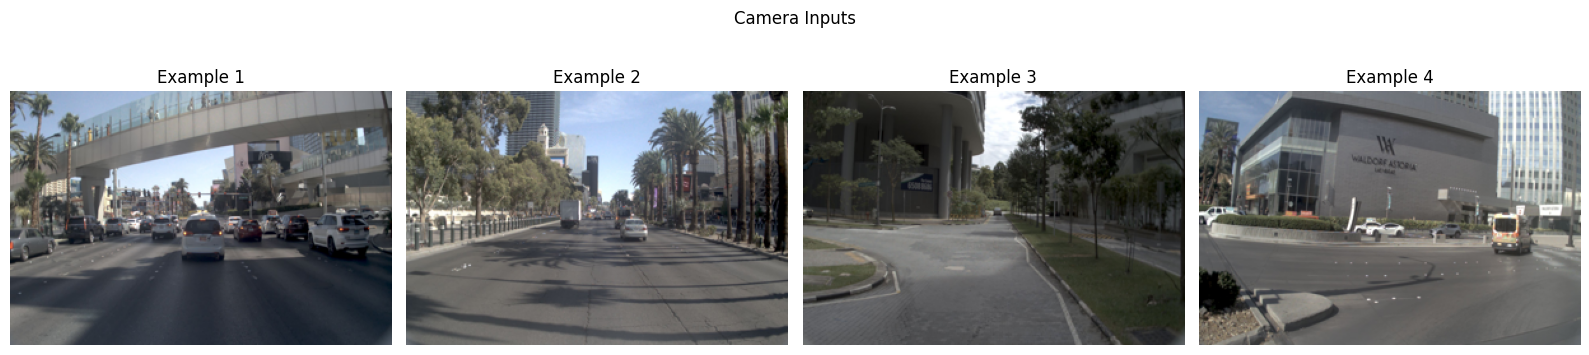

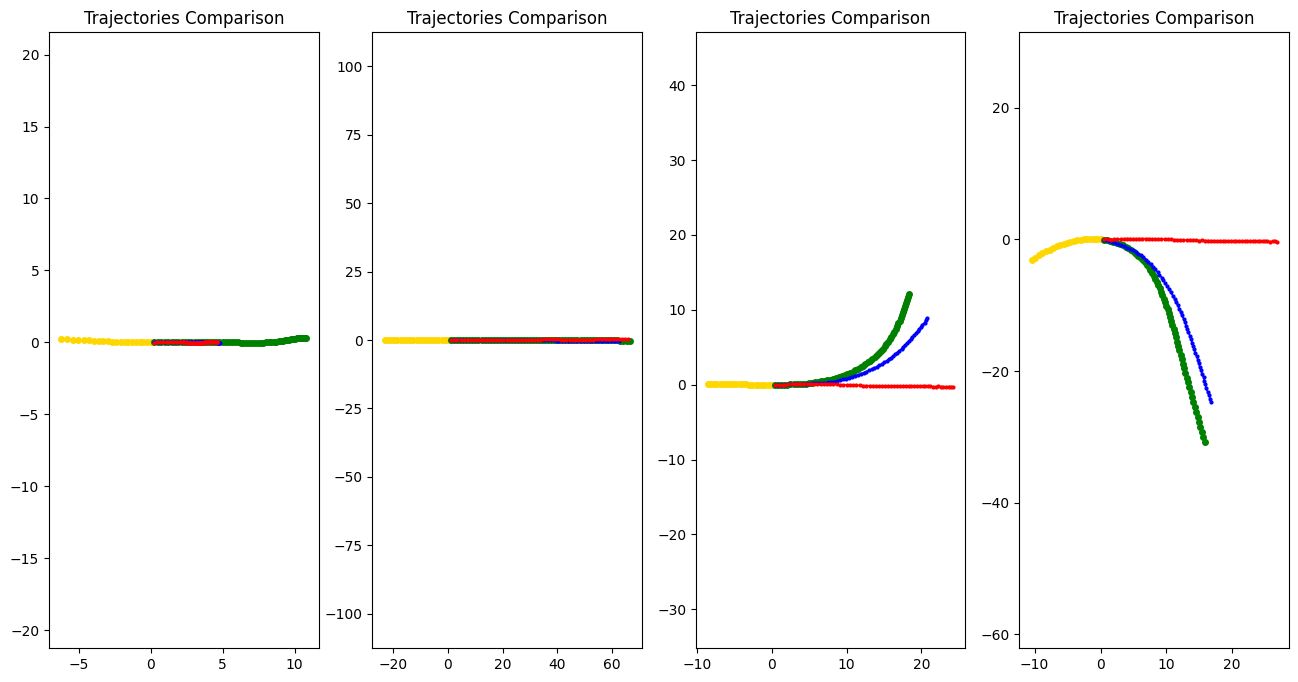

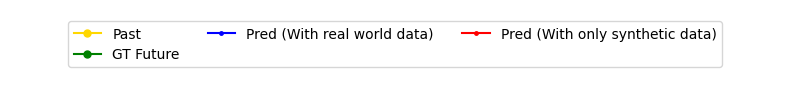

<Figure size 640x480 with 0 Axes>

array([[[ 9.1855839e-02,  2.5145200e-03, -3.1599659e-06],
        [ 1.9013190e-01,  5.1273648e-03,  1.6049641e-04],
        [ 2.9697689e-01,  8.5713342e-03,  1.4558338e-04],
        ...,
        [ 1.1528519e+01,  2.1982167e-03, -2.7554199e-02],
        [ 1.1886775e+01, -1.5928868e-02, -3.3133287e-02],
        [ 1.2258932e+01, -4.0710252e-02, -3.9478324e-02]],

       [[ 3.4651455e-01, -1.7613068e-02, -1.1285847e-02],
        [ 6.9667733e-01, -4.0055443e-02, -2.3093117e-02],
        [ 1.0463656e+00, -6.6288814e-02, -3.4795012e-02],
        ...,
        [ 1.8739697e+01, -7.2349024e+00, -6.3994992e-01],
        [ 1.9035536e+01, -7.4754410e+00, -6.5247804e-01],
        [ 1.9328362e+01, -7.7201109e+00, -6.6428089e-01]],

       [[ 6.2487459e-01,  7.8946236e-05, -3.2979320e-04],
        [ 1.2403232e+00,  1.8836005e-04, -6.8786414e-04],
        [ 1.8431702e+00, -4.0774079e-04, -8.7218621e-04],
        ...,
        [ 2.7104773e+01, -2.8980055e-01, -1.3751816e-02],
        [ 2.7475554e+01, -2.9

In [ ]:
model_real = LightningDrivingPlannerWithPretraining.load_from_checkpoint("checkpoints/phase3/Optuna_Trial_loss_based_1000_val/version_0_epoch=27_val_traj_loss=0.7769_val_ade=1.4978.ckpt")
model_syn = LightningDrivingPlannerWithPretraining.load_from_checkpoint("checkpoints/phase3/M2ToM3_1000_val/version_2_epoch=27_val_traj_loss=0.7868_val_ade=1.4461.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_real.to(device)
model_syn.to(device)
visualize_comparison(val_loader, model_real, model_syn, device)

## Hyperparameter tuning

In [ ]:

import optuna

def objective(trial):
    import torch
    import random
    import numpy as np

    
    # Load dataset paths 
    train_files = [os.path.join("data", "phase3", "train", f) for f in os.listdir("data/phase3/train") if f.endswith('.pkl')]
    val_files = [os.path.join("data", "phase3", "val_real", f) for f in os.listdir("data/phase3/val_real") if f.endswith('.pkl')]
    augmented_train_files = [os.path.join("data", "phase3", "augmented_train", f) for f in os.listdir("data/phase3/augmented_train") if f.endswith('.pkl')]
    augmented_val_files = [os.path.join("data", "phase3", "augmented_val", f) for f in os.listdir("data/phase3/augmented_val") if f.endswith('.pkl')]

    all_train_files = train_files + augmented_train_files
    all_val_files = val_files + augmented_val_files
    random.shuffle(all_train_files)
    random.shuffle(all_val_files)

    # mix the val dataset into training dataset
    train_files = all_train_files + all_val_files[:500]
    val_files = all_val_files[500:]

    def worker_init_fn(worker_id):
        seed = torch.initial_seed() % 2**32
        np.random.seed(seed)
        random.seed(seed)

    # Set consistent seed for each trial
    seed = 42 + trial.number
    pl.seed_everything(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Hyperparameter search space
    lr = trial.suggest_loguniform("lr", 1e-6, 1e-3)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)

    # Reload fresh dataset inside each trial
    train_dataset = DrivingDataset(train_files)
    val_dataset = DrivingDataset(val_files)

    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
    )

    try:
        best_model_path = run_experiment_with_pretrained(
            train_loader=train_loader,
            val_loader=val_loader,
            max_epochs=60,  # reduce for faster tuning
            lr=lr,
            weight_decay=weight_decay,
            beta=1,
            depth_k=0,
            semantic_k=0,
            dynamic_weighting=True,
            logger_name="Optuna_Trial_loss_based",
            pretrained_model_path="checkpoints\\phase1\\old_checkpoints\\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"
        )

        # Reload model to evaluate on val again
        model = LightningDrivingPlannerWithPretraining.load_from_checkpoint(best_model_path)
        trainer = pl.Trainer(accelerator='gpu' if torch.cuda.is_available() else 'cpu', devices=1)
        val_result = trainer.validate(model, val_loader, verbose=False)
        val_ade = val_result[0]["val_ade"]
        print("val_ade for best model: ", val_ade)
        return val_ade

    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return float("inf")  # penalize failed trials


In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)


# Run Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

print("\nBest trial:")
print(f"  val_ade: {study.best_value}")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")



Model initialized with parameters:
Learning Rate: 0.0001
Weight Decay: 4.6387e-06
Number of Epochs: 30
Number of Modes: 4
depth_k: 0
semantic_k: 0
Dynamic weighting: True

Loading pretrained model from checkpoints\phase1\old_checkpoints\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt
Loaded pretrained model. Missing keys: 14, Unexpected keys: 4


Missing keys: ['model.image_encoder.feature_reduction.weight', 'model.image_encoder.feature_reduction.bias', 'model.image_encoder.visual_fc.weight', 'model.image_encoder.visual_fc.bias', 'model.fusion.1.weight', 'model.fusion.1.bias', 'model.fusion.1.running_mean', 'model.fusion.1.running_var', 'model.fusion.4.weight', 'model.fusion.4.bias', 'model.fusion.5.weight', 'model.fusion.5.bias', 'model.fusion.5.running_mean', 'model.fusion.5.running_var']


Unexpected keys: ['model.visual_fc.weight', 'model.visual_fc.bias', 'model.fusion.2.weight', 'model.fusion.2.bias']


C:\Users\Mert\AppData\Local\Temp\ipykernel_18028\2509490383.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(self.pretrained_model_path, map_loca


Model initialized with parameters:
Learning Rate: 0.0009099089538170392
Weight Decay: 2.3965066278527173e-05
Number of Epochs: 60
Number of Modes: 4
depth_k: 0
semantic_k: 0
Dynamic weighting: True

Loading pretrained model from checkpoints\phase1\old_checkpoints\driving_planner_version_68_epoch=107_val_ade=1.55.ckpt
Loaded pretrained model. Missing keys: 14, Unexpected keys: 4


Missing keys: ['model.image_encoder.feature_reduction.weight', 'model.image_encoder.feature_reduction.bias', 'model.image_encoder.visual_fc.weight', 'model.image_encoder.visual_fc.bias', 'model.fusion.1.weight', 'model.fusion.1.bias', 'model.fusion.1.running_mean', 'model.fusion.1.running_var', 'model.fusion.4.weight', 'model.fusion.4.bias', 'model.fusion.5.weight', 'model.fusion.5.bias', 'model.fusion.5.running_mean', 'model.fusion.5.running_var']


Unexpected keys: ['model.visual_fc.weight', 'model.visual_fc.bias', 'model.fusion.2.weight', 'model.fusion.2.bias']


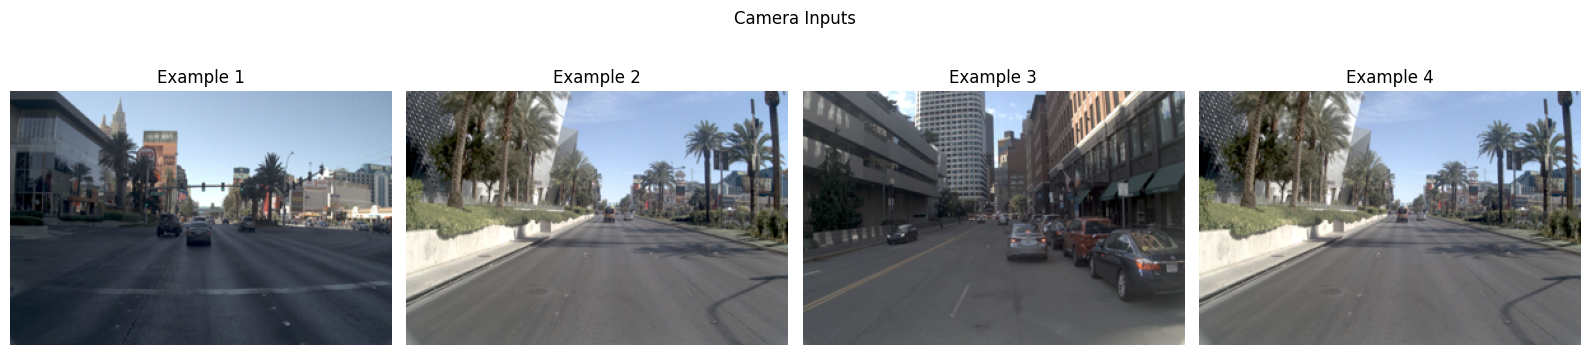

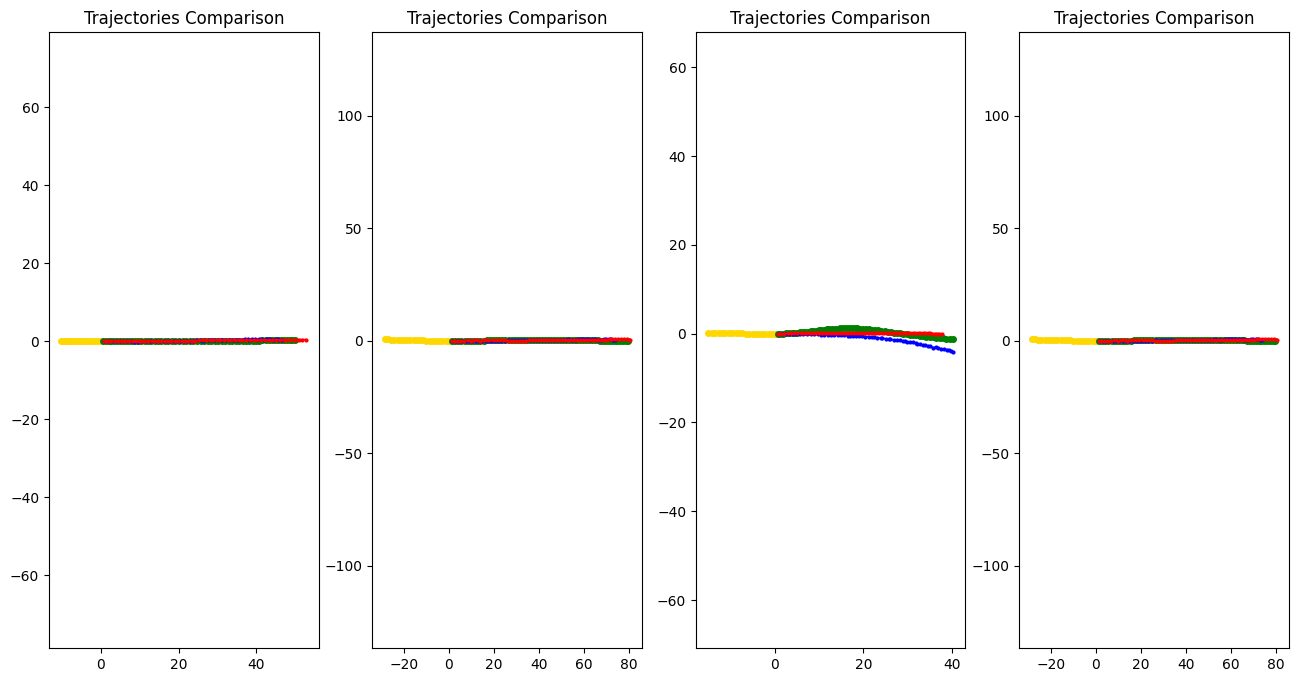

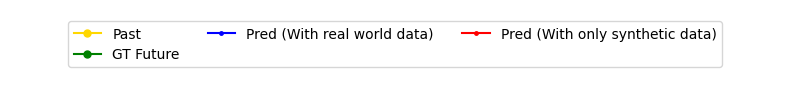

<Figure size 640x480 with 0 Axes>

array([[[ 6.41325191e-02,  1.64786557e-04,  5.27724158e-04],
        [ 1.17837273e-01, -1.81610906e-03,  2.16047265e-04],
        [ 1.63389653e-01, -3.20739858e-03, -5.19504712e-04],
        ...,
        [ 2.04193100e-01, -4.83269291e-03, -2.30421894e-04],
        [ 2.21032798e-01, -4.97786095e-03, -1.56457201e-04],
        [ 2.44853228e-01, -4.25058324e-03, -7.44747886e-05]],

       [[ 1.16335154e+00, -2.60272482e-03, -5.37960295e-05],
        [ 2.33173180e+00, -5.63930860e-03, -2.41110654e-04],
        [ 3.51170731e+00, -1.00289127e-02, -2.50389829e-04],
        ...,
        [ 6.91214523e+01, -5.32120407e-01, -5.35664801e-03],
        [ 7.03486404e+01, -5.42346954e-01, -5.08428505e-03],
        [ 7.15845261e+01, -5.52909791e-01, -4.67638765e-03]],

       [[ 9.89261329e-01, -2.17745919e-03, -4.66328667e-04],
        [ 1.97066689e+00, -4.11244138e-04, -1.41776865e-04],
        [ 2.95862961e+00,  1.40801328e-03,  6.41034640e-05],
        ...,
        [ 6.32395706e+01, -2.36266032e-01,

In [ ]:

# Load dataset paths only once
train_files = [os.path.join("data", "phase3", "train", f) for f in os.listdir("data/phase3/train") if f.endswith('.pkl')]
val_files = [os.path.join("data", "phase3", "val_real", f) for f in os.listdir("data/phase3/val_real") if f.endswith('.pkl')]
augmented_train_files = [os.path.join("data", "phase3", "augmented_train", f) for f in os.listdir("data/phase3/augmented_train") if f.endswith('.pkl')]
augmented_val_files = [os.path.join("data", "phase3", "augmented_val", f) for f in os.listdir("data/phase3/augmented_val") if f.endswith('.pkl')]

# Add augmentations and shuffle the datasets
all_train_files = train_files + augmented_train_files
all_val_files = val_files + augmented_val_files
random.shuffle(all_train_files)
random.shuffle(all_val_files)

# mix the val dataset into training dataset
train_files = all_train_files + all_val_files[:500]
val_files = all_val_files[500:]

# Reload fresh dataset inside each trial
train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
)


model_real = LightningDrivingPlannerWithPretraining.load_from_checkpoint("checkpoints/phase3/trials/version_4_epoch=29_val_traj_loss=1.2401.ckpt")
model_syn = LightningDrivingPlannerWithPretraining.load_from_checkpoint("checkpoints/phase3/Optuna_Trial_loss_based/version_28_epoch=58_val_traj_loss=0.8378_val_ade=1.4847.ckpt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_real.to(device)
model_syn.to(device)
visualize_comparison(val_loader, model_real, model_syn, device)

## Generate Submission

In [25]:
class EnhancedDrivingPlanner(nn.Module):
    def __init__(self, num_modes=4, lr=1e-4, future_steps=60, include_heading=False,
                 semantic_output_size=(200, 300), num_semantic_classes=15):
        super().__init__()

        self.num_modes = num_modes
        self.future_steps = future_steps
        self.include_heading = include_heading
        self.semantic_output_size = semantic_output_size
        self.num_semantic_classes = num_semantic_classes

        # Visual encoder: ResNet18 pretrained
        resnet = models.resnet18(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc layers
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        self.visual_fc = nn.Linear(512, 256)  # ResNet18 last conv outputs 512 channels

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )

        # Semantic Decoder - Fixed to work with feature maps
        # We need to work with the feature maps before pooling for semantic segmentation
        self.semantic_decoder = nn.Sequential(
            # Start from ResNet feature maps (B, 512, H/32, W/32)
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Final upsampling and classification
            nn.ConvTranspose2d(32, self.num_semantic_classes, kernel_size=4, stride=2, padding=1),
        )

        # Trajectory decoder
        if include_heading:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 3)
        else:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 2)  # (x, y) only, no heading
        self.confidence_head = nn.Linear(512, num_modes)  # One confidence score per mode

    def forward(self, camera, history):
        batch_size = camera.size(0)

        # Encode image - keep feature maps for semantic segmentation
        visual_feature_maps = self.visual_encoder(camera)  # (B, 512, H', W')

        # For trajectory prediction, pool the features
        visual_features_pooled = self.visual_pool(visual_feature_maps).view(batch_size, -1)  # (B, 512)
        visual_features = self.visual_fc(visual_features_pooled)  # (B, 256)

        # Encode history
        history_flat = history.reshape(batch_size, -1)
        history_features = self.history_encoder(history_flat)  # (B, 128)

        # Fuse for trajectory prediction
        fused = self.fusion(torch.cat([visual_features, history_features], dim=1))  # (B, 512)

        # Predict Trajectory
        traj = self.trajectory_head(fused)  # (B, num_modes * future_steps * 2)
        if self.include_heading:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 3)
        else:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 2)

        conf = self.confidence_head(fused)  # (B, num_modes)
        conf = torch.softmax(conf, dim=-1)  # Confidence scores across modes

        # Predict semantic segmentation using feature maps
        semantic_pred_logits = self.semantic_decoder(visual_feature_maps)  # (B, num_classes, H, W)

        # Resize to target output size if needed
        if semantic_pred_logits.shape[-2:] != self.semantic_output_size:
            semantic_pred_logits = F.interpolate(
                semantic_pred_logits,
                size=self.semantic_output_size,
                mode="bilinear",
                align_corners=False
            )

        return traj, conf, semantic_pred_logits

    def compute_loss(self, traj_pred, conf_pred, future, semantic_pred_logits, semantic_gt,
                     semantic_weight=0.5):
        # Trajectory loss
        if self.include_heading:
            future_expand = future[:, None, :, :3].expand_as(traj_pred)
        else:
            future_expand = future[:, None, :, :2].expand_as(traj_pred)

        # Compute loss for each mode
        loss_per_mode = nn.SmoothL1Loss(reduction='none')(traj_pred, future_expand).mean(dim=[2,3])  # (B, num_modes)
        # Confidence-weighted loss
        trajectory_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

        # Semantic loss
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred_logits, semantic_gt)

        # Combined loss
        combined_loss = trajectory_loss + semantic_weight * semantic_loss

        return combined_loss, trajectory_loss, semantic_loss


In [45]:
class LightningSimplifiedDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, num_modes=4,
                 scheduler_factor=0.95, scheduler_patience=5, include_heading=False,
                 semantic_output_size=(200, 300), num_semantic_classes=15, semantic_weight=0.5):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.semantic_weight = semantic_weight

        self.planner = EnhancedDrivingPlanner(
            num_modes=num_modes,
            include_heading=include_heading,
            semantic_output_size=semantic_output_size,
            num_semantic_classes=num_semantic_classes
        )

        self.scheduler_factor = scheduler_factor
        self.scheduler_patience = scheduler_patience
        self.include_heading = include_heading
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Factor: {self.scheduler_factor}")
        print(f"Scheduler Patience: {self.scheduler_patience}")
        print(f"Include Heading: {include_heading}")
        print(f"Semantic Classes: {num_semantic_classes}")
        print(f"Semantic Weight: {semantic_weight}")

    def forward(self, camera, history):
        return self.planner(camera, history)

    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        semantic_labels = batch['semantic'] # [B, H, W]

        # Forward pass
        pred_trajs, confidences, semantic_pred_logits = self(camera, history)

        # Compute loss
        combined_loss, traj_loss, semantic_loss = self.planner.compute_loss(
            pred_trajs, confidences, future, semantic_pred_logits, semantic_labels,
            semantic_weight=self.semantic_weight
        )

        # Log losses
        self.log('train_loss', combined_loss, prog_bar=True)
        self.log('train_traj_loss', traj_loss, prog_bar=False)
        self.log('train_semantic_loss', semantic_loss, prog_bar=False)

        return combined_loss

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        semantic_labels = batch['semantic']

        # Forward pass
        pred_trajs, confidences, semantic_pred_logits = self(camera, history)

        # Compute losses
        combined_loss, traj_loss, semantic_loss = self.planner.compute_loss(
            pred_trajs, confidences, future, semantic_pred_logits, semantic_labels,
            semantic_weight=self.semantic_weight
        )

        # Compute ADE and FDE
        ade, fde = compute_ade_fde(pred_trajs, future, self.include_heading, confidences)

        # Compute semantic accuracy
        semantic_pred = torch.argmax(semantic_pred_logits, dim=1)
        semantic_acc = (semantic_pred == semantic_labels).float().mean()

        # Log validation metrics
        self.log('val_loss', combined_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=False, sync_dist=True)
        self.log('val_semantic_loss', semantic_loss, prog_bar=False, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)
        self.log('val_semantic_acc', semantic_acc, prog_bar=True, sync_dist=True)

        return {
            'val_loss': combined_loss,
            'val_ade': ade,
            'val_fde': fde,
            'val_semantic_acc': semantic_acc
        }

    def test_step(self, batch, batch_idx):
        # Don't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=self.scheduler_factor,
            patience=self.scheduler_patience,
            min_lr=1e-6,
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_ade',
                'interval': 'epoch',
                'frequency': 1,
                'reduce_on_plateau': True
            }
        }


In [43]:

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])
        #if data.keys include 'semantic_label', then use it
        if 'semantic_label' in data:
            semantic = torch.LongTensor(data['semantic_label'])
            if semantic.shape[-2:] != (200, 300):
                semantic = TF.resize(semantic.unsqueeze(0).float(), size=(200, 300), interpolation=TF.InterpolationMode.NEAREST).long().squeeze(0)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'future': future,
                'semantic': semantic
            }
        else:
            if 'semantic_label' in data:
                return {
                    'camera': camera,
                    'history': history,
                    'semantic': semantic
                }
            else:
                return {
                    'camera': camera,
                    'history': history
                }

In [ ]:

import pandas as pd
model = LightningSimplifiedDrivingPlanner.load_from_checkpoint("checkpoints\\phase3\\milestone3\\version_9_epoch=28_val_traj_loss=0.6055_val_ade=1.3990.ckpt")


test_data_dir = os.path.join("data", "phase3", "test_public_real")
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250)
model.eval()
model.to('cuda')
all_plans = []
device = 'cuda'
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future, _, _ = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)
print(f"Shape of pred_xy: {pred_xy.shape}")
# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("aug_all_g3_n4_br5_bl2_val_loss_0.6055_val_ade_1.3990.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

## TEST

In [2]:
import csv
import os
import pickle
import random
import re

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from albumentations.pytorch import ToTensorV2
from pytorch_lightning import LightningModule, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import functional as TF

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import pickle
from tqdm import tqdm
import cv2

import csv
import random


class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        history = torch.FloatTensor(data['sdc_history_feature'])

        semantic = torch.LongTensor(data['semantic_label'])
        if semantic.shape[-2:] != (200, 300):
            semantic = TF.resize(semantic.unsqueeze(0).float(), size=(200, 300), interpolation=TF.InterpolationMode.NEAREST).long().squeeze(0)

        if not self.test:
            future = torch.FloatTensor(data['sdc_future_feature'])
            return {
                'camera': camera,
                'history': history,
                'future': future,
                'semantic': semantic
            }
        else:
            return {
                'camera': camera,
                'history': history,
                'semantic': semantic
            }


def compute_ade_fde(pred_trajectories, gt_trajectory, include_heading=False, confidences=None):
    """
    Compute Average Displacement Error and Final Displacement Error

    Args:
        pred_trajectories: Tensor of shape [B, M, T, 2] where M is number of modes
        gt_trajectory: Tensor of shape [B, T, 2+] (the + indicates there might be more features)

    Returns:
        ade: Average Displacement Error across all timesteps
        fde: Final Displacement Error (last timestep only)
    """
    # Extract only x, y coordinates from ground truth if needed
    if include_heading:
        gt_xy = gt_trajectory[..., :3]
    else:
        gt_xy = gt_trajectory[..., :2]

    # Calculate per-mode errors
    error_per_mode = torch.norm(pred_trajectories - gt_xy.unsqueeze(1), dim=-1)  # [B, M, T]

    # If confidences are provided, use them to select best mode
    if confidences is not None:
        best_mode_idx = confidences.argmax(dim=1)  # [B] - Use highest confidence
    else:
        # Fall back to minimum ADE if no confidences provided
        mode_ade = error_per_mode.mean(dim=2)  # [B, M]
        best_mode_idx = mode_ade.argmin(dim=1)  # [B]

    # Get errors for best mode per batch element
    batch_indices = torch.arange(pred_trajectories.size(0), device=pred_trajectories.device)
    best_mode_error = error_per_mode[batch_indices, best_mode_idx]  # [B, T]

    # Compute metrics
    ade = best_mode_error.mean().item()
    fde = best_mode_error[:, -1].mean().item()

    return ade, fde

class EnhancedDrivingPlanner(nn.Module):
    def __init__(self, num_modes=4, lr=1e-4, future_steps=60, include_heading=False,
                 semantic_output_size=(200, 300), num_semantic_classes=15):
        super().__init__()

        self.num_modes = num_modes
        self.future_steps = future_steps
        self.include_heading = include_heading
        self.semantic_output_size = semantic_output_size
        self.num_semantic_classes = num_semantic_classes

        # Visual encoder: ResNet18 pretrained
        resnet = models.resnet18(pretrained=True)
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-2])  # Remove avgpool and fc layers
        self.visual_pool = nn.AdaptiveAvgPool2d((1, 1))  # Pool to (batch, channels, 1, 1)
        self.visual_fc = nn.Linear(512, 256)  # ResNet18 last conv outputs 512 channels

        # History encoder
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(256 + 128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU()
        )

        # Semantic Decoder - Fixed to work with feature maps
        # We need to work with the feature maps before pooling for semantic segmentation
        self.semantic_decoder = nn.Sequential(
            # Start from ResNet feature maps (B, 512, H/32, W/32)
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Upsample by 2x
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Final upsampling and classification
            nn.ConvTranspose2d(32, self.num_semantic_classes, kernel_size=4, stride=2, padding=1),
        )

        # Trajectory decoder
        if include_heading:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 3)
        else:
            self.trajectory_head = nn.Linear(512, num_modes * future_steps * 2)  # (x, y) only, no heading
        self.confidence_head = nn.Linear(512, num_modes)  # One confidence score per mode

    def forward(self, camera, history):
        batch_size = camera.size(0)

        # Encode image - keep feature maps for semantic segmentation
        visual_feature_maps = self.visual_encoder(camera)  # (B, 512, H', W')

        # For trajectory prediction, pool the features
        visual_features_pooled = self.visual_pool(visual_feature_maps).view(batch_size, -1)  # (B, 512)
        visual_features = self.visual_fc(visual_features_pooled)  # (B, 256)

        # Encode history
        history_flat = history.reshape(batch_size, -1)
        history_features = self.history_encoder(history_flat)  # (B, 128)

        # Fuse for trajectory prediction
        fused = self.fusion(torch.cat([visual_features, history_features], dim=1))  # (B, 512)

        # Predict Trajectory
        traj = self.trajectory_head(fused)  # (B, num_modes * future_steps * 2)
        if self.include_heading:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 3)
        else:
            traj = traj.view(batch_size, self.num_modes, self.future_steps, 2)

        conf = self.confidence_head(fused)  # (B, num_modes)
        conf = torch.softmax(conf, dim=-1)  # Confidence scores across modes

        # Predict semantic segmentation using feature maps
        semantic_pred_logits = self.semantic_decoder(visual_feature_maps)  # (B, num_classes, H, W)

        # Resize to target output size if needed
        if semantic_pred_logits.shape[-2:] != self.semantic_output_size:
            semantic_pred_logits = F.interpolate(
                semantic_pred_logits,
                size=self.semantic_output_size,
                mode="bilinear",
                align_corners=False
            )

        return traj, conf, semantic_pred_logits

    def compute_loss(self, traj_pred, conf_pred, future, semantic_pred_logits, semantic_gt,
                     semantic_weight=0.5):
        # Trajectory loss
        if self.include_heading:
            future_expand = future[:, None, :, :3].expand_as(traj_pred)
        else:
            future_expand = future[:, None, :, :2].expand_as(traj_pred)

        # Compute loss for each mode
        loss_per_mode = nn.SmoothL1Loss(reduction='none')(traj_pred, future_expand).mean(dim=[2,3])  # (B, num_modes)
        # Confidence-weighted loss
        trajectory_loss = (loss_per_mode * conf_pred).sum(dim=1).mean()

        # Semantic loss
        semantic_loss = nn.CrossEntropyLoss()(semantic_pred_logits, semantic_gt)

        # Combined loss
        combined_loss = trajectory_loss + semantic_weight * semantic_loss

        return combined_loss, trajectory_loss, semantic_loss


class LightningSimplifiedDrivingPlanner(pl.LightningModule):
    def __init__(self, lr=1e-4, weight_decay=1e-4, epochs=50, num_modes=4,
                 scheduler_factor=0.95, scheduler_patience=5, include_heading=False,
                 semantic_output_size=(200, 300), num_semantic_classes=15, semantic_weight=0.5):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.semantic_weight = semantic_weight

        self.planner = EnhancedDrivingPlanner(
            num_modes=num_modes,
            include_heading=include_heading,
            semantic_output_size=semantic_output_size,
            num_semantic_classes=num_semantic_classes
        )

        self.scheduler_factor = scheduler_factor
        self.scheduler_patience = scheduler_patience
        self.include_heading = include_heading
        self.save_hyperparameters()

        print("\n====================================\nModel initialized with parameters:")
        print(f"Learning Rate: {self.lr}")
        print(f"Weight Decay: {self.weight_decay}")
        print(f"Number of Epochs: {self.epochs}")
        print(f"Number of Modes: {num_modes}")
        print(f"Scheduler Factor: {self.scheduler_factor}")
        print(f"Scheduler Patience: {self.scheduler_patience}")
        print(f"Include Heading: {include_heading}")
        print(f"Semantic Classes: {num_semantic_classes}")
        print(f"Semantic Weight: {semantic_weight}")

    def forward(self, camera, history):
        return self.planner(camera, history)

    def training_step(self, batch, batch_idx):
        camera = batch['camera']           # [B,3,H,W]
        history = batch['history']         # [B, T, 3]
        future = batch['future']           # [B, T, 3]
        semantic_labels = batch['semantic'] # [B, H, W]

        # Forward pass
        pred_trajs, confidences, semantic_pred_logits = self(camera, history)

        # Compute loss
        combined_loss, traj_loss, semantic_loss = self.planner.compute_loss(
            pred_trajs, confidences, future, semantic_pred_logits, semantic_labels,
            semantic_weight=self.semantic_weight
        )

        # Log losses
        self.log('train_loss', combined_loss, prog_bar=True)
        self.log('train_traj_loss', traj_loss, prog_bar=False)
        self.log('train_semantic_loss', semantic_loss, prog_bar=False)

        return combined_loss

    def validation_step(self, batch, batch_idx):
        camera = batch['camera']
        history = batch['history']
        future = batch['future']
        semantic_labels = batch['semantic']

        # Forward pass
        pred_trajs, confidences, semantic_pred_logits = self(camera, history)

        # Compute losses
        combined_loss, traj_loss, semantic_loss = self.planner.compute_loss(
            pred_trajs, confidences, future, semantic_pred_logits, semantic_labels,
            semantic_weight=self.semantic_weight
        )

        # Compute ADE and FDE
        ade, fde = compute_ade_fde(pred_trajs, future, self.include_heading, confidences)

        # Compute semantic accuracy
        semantic_pred = torch.argmax(semantic_pred_logits, dim=1)
        semantic_acc = (semantic_pred == semantic_labels).float().mean()

        # Log validation metrics
        self.log('val_loss', combined_loss, prog_bar=True, sync_dist=True)
        self.log('val_traj_loss', traj_loss, prog_bar=False, sync_dist=True)
        self.log('val_semantic_loss', semantic_loss, prog_bar=False, sync_dist=True)
        self.log('val_ade', ade, prog_bar=True, sync_dist=True)
        self.log('val_fde', fde, prog_bar=True, sync_dist=True)
        self.log('val_semantic_acc', semantic_acc, prog_bar=True, sync_dist=True)

        return {
            'val_loss': combined_loss,
            'val_ade': ade,
            'val_fde': fde,
            'val_semantic_acc': semantic_acc
        }

    def test_step(self, batch, batch_idx):
        # Don't do anything because we don't have the ground truth
        return {}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay
        )

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=self.scheduler_factor,
            patience=self.scheduler_patience,
            min_lr=1e-6,
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_ade',
                'interval': 'epoch',
                'frequency': 1,
                'reduce_on_plateau': True
            }
        }

def adjust_brightness(image, bright_thresh=110, dark_thresh=90):
    """
    Adjust brightness adaptively and safely.
    - Input: image in uint8 format
    - Output: image in uint8 format
    """
    if image.dtype != np.uint8:
        raise ValueError("Expected input image in uint8 format")

    # Compute mean brightness from grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = gray.mean()
    # Choose factor based on brightness level
    if mean_brightness > bright_thresh:
        factor = np.random.uniform(0.5, 0.8)  # darken
    elif mean_brightness < dark_thresh:
        factor = np.random.uniform(1.2, 1.5)  # brighten
    else:
        factor = np.random.uniform(0.8, 1.2)  # mild change

    # Convert to float for safe scaling
    image = image.astype(np.float32)
    image = image * factor
    image = np.clip(image, 0, 255)
    return image.astype(np.uint8)

def apply_blur(image):
    k = random.choice([1, 3, 5])
    return cv2.GaussianBlur(image, (k, k), 0)

def add_noise(image, noise_level=15):
    noise = np.random.normal(0, noise_level, image.shape).astype(np.int16)
    image = np.clip(image.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return image

def apply_gamma(image, gamma_range=(0.5, 1.5)):
    gamma = np.random.uniform(*gamma_range)
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    return cv2.LUT(image, table)

# --- Helper to apply and save ---

def apply_augmentation_to_subset(file_list, save_dir, augmentation_fn, suffix, ratio):
    os.makedirs(save_dir, exist_ok=True)
    new_files = []

    selected_files = random.sample(file_list, int(len(file_list) * ratio))

    for file_path in tqdm(selected_files, desc=f"Applying {suffix}"):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        image = data['camera']
        aug_image = augmentation_fn(image)
        data['camera'] = aug_image
        base = os.path.basename(file_path)
        new_filename = f"{suffix}_{base}"
        new_path = os.path.join(save_dir, new_filename)

        with open(new_path, 'wb') as f:
            pickle.dump(data, f)

        new_files.append(new_path)

    return new_files

# --- Main driver ---

def incremental_augmentation(file_list, save_dir, ratios):
    os.makedirs(save_dir, exist_ok=True)
    all_files = list(file_list)  # Start with original + flipped

    stage1 = apply_augmentation_to_subset(
        all_files, save_dir, apply_gamma, 'gamma', ratios.get('gamma', 0.5)
    )
    all_files += stage1

    stage2 = apply_augmentation_to_subset(
        all_files, save_dir, add_noise, 'noise', ratios.get('noise', 0.5)
    )
    all_files += stage2

    stage3 = apply_augmentation_to_subset(
        all_files, save_dir, adjust_brightness, 'bright', ratios.get('brightness', 0.5)
    )
    all_files += stage3

    stage4 = apply_augmentation_to_subset(
        all_files, save_dir, apply_blur, 'blur', ratios.get('blur', 0.5)
    )
    all_files += stage4

    return all_files

from collections import defaultdict

def count_augmentation_variants(file_paths):
    """
    Given a list of file paths, returns a dictionary counting how many files
    belong to each augmentation suffix (e.g., 'flipped', 'gamma', 'bright', etc.)
    """

    counts = defaultdict(int)

    for path in file_paths:
        filename = os.path.basename(path)
        name_parts = filename.split('_')

        # Collect all known prefixes (excluding index and extension)
        suffixes = name_parts[:-1] if len(name_parts) > 1 else ['original']
        key = '+'.join(sorted(suffixes)) if suffixes else 'original'

        counts[key] += 1

    return dict(counts)

# Updated loading functions to handle the new architecture
def load_pretrained_encoders_multitask(model, checkpoint_path, load_visual=True, load_history=True,
                                      strict=False, skip_semantic=F):
    """
    Load pretrained encoders for the multi-task model, optionally skipping semantic decoder.

    Args:
        model: Your current multi-task model instance
        checkpoint_path: Path to the checkpoint file
        load_visual: Whether to load the visual encoder weights
        load_history: Whether to load the history encoder weights
        strict: Whether to strictly match all keys
        skip_semantic: Whether to skip loading semantic decoder (useful when loading from single-task model)
    """

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    # Extract state dict
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    # Get the current model's state dict
    model_state_dict = model.state_dict()

    # Create a new state dict with only the components we want to load
    filtered_state_dict = {}

    if load_visual:
        # Load visual encoder components (but not semantic decoder)
        visual_keys = [
            'planner.visual_encoder',
            'planner.visual_pool',
            'planner.visual_fc'
        ]

        for key in state_dict:
            for visual_key in visual_keys:
                if key.startswith(visual_key):
                    # Handle prefix differences
                    model_key = key
                    if key.startswith('planner.') and not any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                        model_key = key.replace('planner.', '')
                    elif not key.startswith('planner.') and any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                        model_key = 'planner.' + key

                    if model_key in model_state_dict:
                        filtered_state_dict[model_key] = state_dict[key]
                        #print(f"Loading visual encoder key: {key} -> {model_key}")

    if load_history:
        # Load history encoder components
        for key in state_dict:
            if 'history_encoder' in key:
                # Handle prefix differences
                model_key = key
                if key.startswith('planner.') and not any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = key.replace('planner.', '')
                elif not key.startswith('planner.') and any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = 'planner.' + key

                if model_key in model_state_dict:
                    filtered_state_dict[model_key] = state_dict[key]
                    #print(f"Loading history encoder key: {key} -> {model_key}")

    # Also load fusion and trajectory/confidence heads if they exist and match
    other_keys = ['planner.fusion', 'planner.trajectory_head', 'planner.confidence_head']
    for key in state_dict:
        for other_key in other_keys:
            if key.startswith(other_key):
                model_key = key
                if key.startswith('planner.') and not any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = key.replace('planner.', '')
                elif not key.startswith('planner.') and any(mk.startswith('planner.') for mk in model_state_dict.keys()):
                    model_key = 'planner.' + key

                if model_key in model_state_dict:
                    # Check if dimensions match
                    if state_dict[key].shape == model_state_dict[model_key].shape:
                        filtered_state_dict[model_key] = state_dict[key]
                        #print(f"Loading {other_key} key: {key} -> {model_key}")
                    else:
                        print(f"Skipping {key} due to shape mismatch: {state_dict[key].shape} vs {model_state_dict[model_key].shape}")

    # Load the filtered state dict
    missing_keys, unexpected_keys = model.load_state_dict(filtered_state_dict, strict=strict)

    print(f"\nSuccessfully loaded {len(filtered_state_dict)} parameters")
    if missing_keys:
        print(f"Missing keys: {missing_keys}")
    if unexpected_keys:
        print(f"Unexpected keys: {unexpected_keys}")

    return model, missing_keys, unexpected_keys

def worker_init_fn(worker_id):
    seed = torch.initial_seed() % 2**32
    np.random.seed(seed)
    random.seed(seed)



# Modified training function to use the pretrained model weights
def run_experiment_with_pretrained(
    train_loader,
    val_loader,
    pretrained_model_path=None,
    max_epochs=70,
    lr=1e-5,
    weight_decay=2.6551e-6,
    beta=1,
    dynamic_weighting=True,
    logger_name="milestone3",
    semantic_k=0.3,
    freeze_encoders=False,
):
    # Set random seed for reproducibility
    pl.seed_everything(13)
    logger_path = os.path.join("lightning_logs", "phase3")
    if not os.path.exists(logger_path):
        os.makedirs(logger_path)

    # Initialize model with Lightning wrapper that loads pretrained weights
    model = LightningSimplifiedDrivingPlanner()
    pretrained_model_path= "checkpoints/phase1/driving_planner_version_68_epoch=107_val_ade=1.55.ckpt"

    model, missing, unexpected = load_pretrained_encoders_multitask(
        model,
        pretrained_model_path,
        load_visual=True,
        load_history=True,
        strict=False
    )

    # Initialize logger
    logger = TensorBoardLogger(save_dir=logger_path, name=logger_name)
    lr_monitor = LearningRateMonitor(logging_interval="epoch")

    filename = f"version_{logger.version}"
    print(f"Model version: {logger.version}\n====================================\n ")

    checkpoint_path = os.path.join("checkpoints", "phase3")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    checkpoint_dir = os.path.join(checkpoint_path, logger_name)
    checkpoint_callback = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename=filename + "_{epoch:02d}_{val_traj_loss:.4f}_{val_ade:.4f}",
        monitor="val_ade",
        mode="min",
        save_top_k=2,
        save_last=False,
        verbose=False,
    )
    # Create trainer and fit model
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator="auto",
        devices="auto",
        precision=16,  # Use mixed precision
        log_every_n_steps=10,  # Logging freq
        gradient_clip_val=5.0,
        enable_checkpointing=True,
        callbacks=[checkpoint_callback, lr_monitor],
        logger=logger,
    )

    trainer.fit(model, train_loader, val_loader)

    return trainer.checkpoint_callback.best_model_path




In [3]:
seed = 13
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
#train_files = [os.path.join("data", "phase2", "augmented_train", f) for f in os.listdir("data/phase2/augmented_train") if f.endswith('.pkl')]
#train_files1= [os.path.join("data", "phase2", "augmented_val", f) for f in os.listdir("data/phase2/augmented_val") if f.endswith('.pkl')]
train_files = [os.path.join("data", "phase2", "train", f) for f in os.listdir("data/phase2/train") if f.endswith('.pkl')]
val_files_real = [os.path.join("data", "phase3", "val_real_semantics", f) for f in os.listdir("data/phase3/val_real_semantics") if f.endswith('.pkl')]
val_files_synth = [os.path.join("data", "phase2", "val", f) for f in os.listdir("data/phase2/val") if f.endswith('.pkl')]

flipped_train_files = [os.path.join("data", "phase2" , "augmented_train", f) for f in os.listdir("data/phase2/augmented_train") if f.endswith('.pkl')]
flipped_val_files_real = [os.path.join("data", "phase3", "augmented_val_real_semantics", f) for f in os.listdir("data/phase3/augmented_val_real_semantics") if f.endswith('.pkl')]
flipped_val_files_synth = [os.path.join("data", "phase2", "augmented_val", f) for f in os.listdir("data/phase2/augmented_val") if f.endswith('.pkl')]


random.shuffle(val_files_real) 
random.shuffle(val_files_synth)
random.shuffle(train_files)

random.shuffle(flipped_val_files_real)
random.shuffle(flipped_val_files_synth)
random.shuffle(flipped_train_files)

num_samples = int(0.4 * len(flipped_train_files))
flipped_train_files = random.sample(flipped_train_files, num_samples)

num_samples = int(0.4 * len(flipped_val_files_synth))
flipped_val_files_synth = random.sample(flipped_val_files_synth, num_samples)

all_train_files = train_files + flipped_train_files + val_files_real[:len(val_files_real)//2] + flipped_val_files_real[:len(flipped_val_files_real)//2] + val_files_synth[:len(val_files_synth)//2] + flipped_val_files_synth[:len(flipped_val_files_synth)//2]
all_val_files = val_files_real[len(val_files_real)//2:] + flipped_val_files_real[len(flipped_val_files_real)//2:] + val_files_synth + flipped_val_files_synth

ratios = {
    'gamma': 0.3,       # Apply gamma correction to 30%
    'noise': 0.4,       # Apply noise to 40% of the current data
    'brightness': 0.5,
    'blur': 0.2,
}

aug_val_path = os.path.join("data", "phase3", "augmented_val")
if not os.path.exists(aug_val_path):
    augmented_val = incremental_augmentation(all_val_files, save_dir=aug_val_path, ratios=ratios)
else:
    augmented_val = [os.path.join(aug_val_path, f) for f in os.listdir(aug_val_path) if f.endswith('.pkl')]

augmented_train_path = os.path.join("data", "phase3", "augmented_all_train")
if not os.path.exists(augmented_train_path):
    augmented_train = incremental_augmentation(all_train_files, save_dir=augmented_train_path, ratios=ratios)
else:
    augmented_train = [os.path.join(augmented_train_path, f) for f in os.listdir(augmented_train_path) if f.endswith('.pkl')]
    
# Note that the augmented files include 
all_train_files = augmented_train
all_val_files = augmented_val

print("Using ", len(all_train_files), " training files and ", len(all_val_files), " validation files\n")

variant_counts = count_augmentation_variants(all_val_files)
print("Variant counts in validation set:\n")
for variant, count in variant_counts.items():
    print(f"{variant}: {count} files")

variant_counts = count_augmentation_variants(all_train_files)
print("\nVariant counts in training set:\n")
for variant, count in variant_counts.items():
    print(f"{variant}: {count} files")



random.shuffle(all_val_files)
train_dataset = DrivingDataset(all_train_files)
val_dataset = DrivingDataset(all_val_files)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=1, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=1, pin_memory=True)


Using  18770  training files and  1000  validation files

Variant counts in validation set:

flipped: 1000 files

Variant counts in training set:

blur: 1155 files
blur+bright: 581 files
blur+bright+flipped: 278 files
blur+bright+gamma: 187 files
blur+bright+flipped+gamma: 74 files
blur+bright+noise: 236 files
blur+bright+flipped+noise: 101 files
blur+bright+gamma+noise: 62 files
blur+bright+flipped+gamma+noise: 29 files
blur+flipped: 535 files
blur+gamma: 350 files
blur+flipped+gamma: 199 files
blur+noise: 450 files
blur+flipped+noise: 213 files
blur+gamma+noise: 141 files
blur+flipped+gamma+noise: 58 files
bright: 2625 files
bright+flipped: 1269 files
bright+gamma: 901 files
bright+flipped+gamma: 396 files
bright+noise: 1190 files
bright+flipped+noise: 520 files
bright+gamma+noise: 356 files
bright+flipped+gamma+noise: 169 files
gamma: 1702 files
flipped+gamma: 764 files
noise: 2218 files
flipped+noise: 992 files
gamma+noise: 696 files
flipped+gamma+noise: 323 files


In [20]:

k = 4
file_set = random.sample(augmented_val, k)

# load the data
data = []
for i in range(k):
    with open(file_set[i], "rb") as f:
        data.append(pickle.load(f))

data[1].keys()


dict_keys(['camera', 'driving_command', 'sdc_history_feature', 'sdc_future_feature', 'semantic_label'])

In [18]:
ratios = {
    'gamma': 0.3,       # Apply gamma correction to 30%
    'noise': 0.4,       # Apply noise to 40% of the current data
    'brightness': 0.5,
    'blur': 0.2,
}
aug_val_path = os.path.join("data", "phase3", "augmented_val_test")

augmented_val = incremental_augmentation(val_files_real, save_dir=aug_val_path, ratios=ratios)


Applying blur: 100%|██████████| 546/546 [00:01<00:00, 394.46it/s]


In [ ]:


p  = run_experiment_with_pretrained(train_loader, val_loader, max_epochs=50)
print("Best model path: ", p)
print("Done!")